In [1]:
# ============================================================
# Exercise 4 - Cost-Sensitive Learning and Threshold Calibration
# Using Decision Trees on an Imbalanced Dataset
# ============================================================

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc
)
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# 1. Load dataset and artificially increase imbalance
X, y = load_breast_cancer(return_X_y=True)

# Check original class distribution
print("Original class distribution:")
print(f"Class 0: {np.sum(y == 0)} samples")
print(f"Class 1: {np.sum(y == 1)} samples")

# Artificial imbalance: keep only 20% of positive samples (class 1)
# Option 1: Manual undersampling (clearer approach)
idx_0 = np.where(y == 0)[0]
idx_1 = np.where(y == 1)[0]

# Keep all class 0, but only 20% of class 1
n_keep_class1 = int(len(idx_1) * 0.2)
np.random.seed(42)
idx_1_keep = np.random.choice(idx_1, n_keep_class1, replace=False)

# Combine indices and create resampled dataset
idx_keep = np.concatenate([idx_0, idx_1_keep])
np.random.shuffle(idx_keep)  # Shuffle to mix classes
X_res = X[idx_keep]
y_res = y[idx_keep]

print(f"\nAfter undersampling (keeping 20% of class 1):")
print(f"Class 0: {np.sum(y_res == 0)} samples")
print(f"Class 1: {np.sum(y_res == 1)} samples")
print(f"Imbalance ratio: {np.sum(y_res == 0) / np.sum(y_res == 1):.2f}:1")

# Split data with 30% in Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

Original class distribution:
Class 0: 212 samples
Class 1: 357 samples

After undersampling (keeping 20% of class 1):
Class 0: 212 samples
Class 1: 71 samples
Imbalance ratio: 2.99:1


Display the size of X and y before and after resampling

In [3]:
print("Size of X before resampling:", X.shape)
print("Size of y before resampling:", y.shape)
print("Size of X after resampling:", X_res.shape)
print("Size of y after resampling:", y_res.shape)

Size of X before resampling: (569, 30)
Size of y before resampling: (569,)
Size of X after resampling: (283, 30)
Size of y after resampling: (283,)


Display the size of each class

In [4]:
print("Number of samples in class 0 (before):", np.sum(y == 0))
print("Number of samples in class 1 (before):", np.sum(y == 1))
print("Number of samples in class 0 (after):", np.sum(y_res == 0))
print("Number of samples in class 1 (after):", np.sum(y_res == 1))

Number of samples in class 0 (before): 212
Number of samples in class 1 (before): 357
Number of samples in class 0 (after): 212
Number of samples in class 1 (after): 71


In [5]:
# 2. Train Decision Tree (baseline)
tree_default = DecisionTreeClassifier(random_state=42)
tree_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [6]:
# 3. Train Decision Tree with class weighting
tree_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_weighted.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [8]:
# 4. Evaluate both models
def evaluate_model(model, X_test, y_test, label="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    auc_pr = auc(recall, precision)

    print(f"\n=== {label} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC (ROC): {auc_roc:.3f} | AUC (PR): {auc_pr:.3f}")

    return y_proba, auc_roc, auc_pr, (precision, recall, thresholds)


# Baseline model
y_proba_default, auc_roc_default, auc_pr_default, pr_data_default = evaluate_model(tree_default, X_test, y_test, "Default Tree")

# Weighted model
y_proba_weighted, auc_roc_weighted, auc_pr_weighted, pr_data_weighted = evaluate_model(tree_weighted, X_test, y_test, "Weighted Tree")


=== Default Tree ===
              precision    recall  f1-score   support

           0      0.954     0.969     0.961        64
           1      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Confusion Matrix:
[[62  2]
 [ 3 18]]
AUC (ROC): 0.913 | AUC (PR): 0.896

=== Weighted Tree ===
              precision    recall  f1-score   support

           0      0.954     0.969     0.961        64
           1      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Confusion Matrix:
[[62  2]
 [ 3 18]]
AUC (ROC): 0.913 | AUC (PR): 0.896


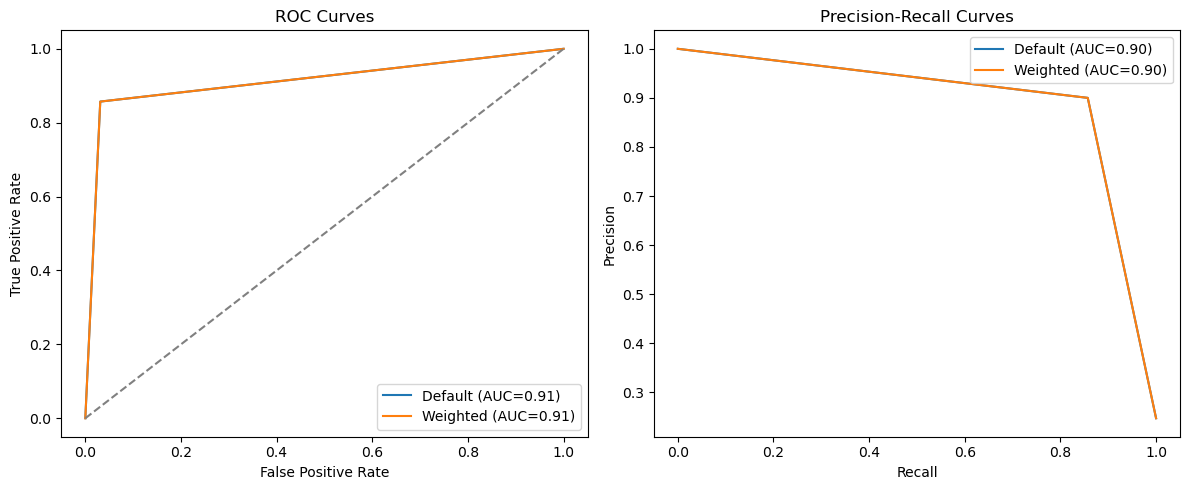

In [9]:
# 5. Plot ROC and Precision-Recall curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
fpr_d, tpr_d, _ = roc_curve(y_test, y_proba_default)
fpr_w, tpr_w, _ = roc_curve(y_test, y_proba_weighted)
plt.plot(fpr_d, tpr_d, label=f"Default (AUC={auc_roc_default:.2f})")
plt.plot(fpr_w, tpr_w, label=f"Weighted (AUC={auc_roc_weighted:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1,2,2)
prec_d, rec_d, _ = pr_data_default
prec_w, rec_w, _ = pr_data_weighted
plt.plot(rec_d, prec_d, label=f"Default (AUC={auc_pr_default:.2f})")
plt.plot(rec_w, prec_w, label=f"Weighted (AUC={auc_pr_weighted:.2f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# 6. Threshold calibration for best F1-score (weighted model)
precision, recall, thresholds = pr_data_weighted
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nOptimal threshold (max F1): {best_threshold:.3f}")
print(f"Best F1-score: {f1_scores[best_idx]:.3f}")


Optimal threshold (max F1): 1.000
Best F1-score: 0.878


In [11]:
# 7. Apply new threshold
y_pred_calibrated = (y_proba_weighted >= best_threshold).astype(int)
print("\n=== Weighted Model (After Threshold Calibration) ===")
print(classification_report(y_test, y_pred_calibrated, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_calibrated))


=== Weighted Model (After Threshold Calibration) ===
              precision    recall  f1-score   support

           0      0.954     0.969     0.961        64
           1      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Confusion Matrix:
[[62  2]
 [ 3 18]]


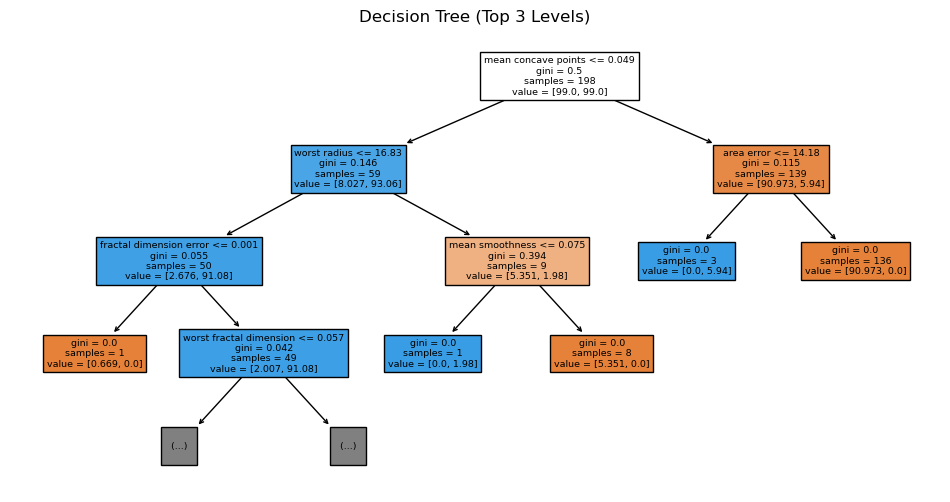

In [12]:
# 8. Visualize the decision tree (optional)
plt.figure(figsize=(12, 6))
plot_tree(tree_weighted, filled=True, feature_names=load_breast_cancer().feature_names, max_depth=3)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()
